In [1]:
%env CUDA_VISIBLE_DEVICES=MIG-768d9c1d-110f-52e2-b0a2-3252f78280f8
import warnings
import torch
import numpy as np
import random
import math
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from types import SimpleNamespace
from datasets import load_dataset
from timm.optim import Mars
from torchvision.transforms.v2 import (
    Compose, RandomCrop, CenterCrop, 
    PILToTensor, ToDtype, MixUp, ToPILImage
)
from fastprogress.fastprogress import master_bar, progress_bar
import copy
import PIL.Image

env: CUDA_VISIBLE_DEVICES=MIG-768d9c1d-110f-52e2-b0a2-3252f78280f8


In [2]:
torch.set_float32_matmul_precision('highest')
device = "cuda:0"
dataset_train = load_dataset('danjacobellis/imagenet_288_webp', split='train')
dataset_valid = load_dataset('danjacobellis/imagenet_288_webp', split='validation')

Resolving data files:   0%|          | 0/66 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/66 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/66 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/66 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/66 [00:00<?, ?it/s]

In [3]:
config = SimpleNamespace()
config.epochs = 48
config.batch_size = 128
config.steps_per_epoch = dataset_train.num_rows // config.batch_size
config.total_steps = config.epochs * config.steps_per_epoch

config.num_workers = 32
config.grad_accum_steps = 1
config.max_lr = 5e-4 * (config.batch_size/128)
config.min_lr = config.max_lr/1e6;
config.lr_pow = 6; assert (config.lr_pow/2)%1 == 0

config.weight_decay = 0.1
config.no_wd_keys = ['norm', 'bias']

config.progressive_sizes = 6*[96] + [128,160,192] + 3*[224]

config.mixup_alpha = 1.0
config.label_smoothing = 0.1

config.mesa = True
config.ema_decay = 0.999
config.mesa_ratio = 2.0
config.mesa_start = 0.25

config.channels=3
config.classifier_num_classes=1000

config.log_filename = 'log_cuda_3'

In [4]:
from timm.models.efficientvit_mit import EfficientVitLarge, GELUTanh

class GroupNorm8(torch.nn.Module):
    def __init__(self, num_features, eps=1e-7, affine=True):
        super().__init__()
        self.groupnorm = torch.nn.GroupNorm(num_groups=8,
                                      num_channels=num_features,
                                      eps=eps,
                                      affine=affine)
    def forward(self, x):
        return self.groupnorm(x)

model = EfficientVitLarge(
    in_chans=config.channels,
    widths=(32, 64, 128, 256, 512),
    depths=(1, 1, 1, 6, 6),
    head_dim=32,
    norm_layer=GroupNorm8,
    act_layer=GELUTanh,
    global_pool='avg',
    head_widths=(3072, 3200),
    drop_rate=0.0,
    num_classes=config.classifier_num_classes
)
model.head.in_conv.norm = torch.nn.GroupNorm(
    num_groups=8,
    num_channels=model.head.in_conv.norm.num_features,
    affine=model.head.in_conv.norm.affine,
    eps=model.head.in_conv.norm.eps
)

model.to(device)

print(sum(p.numel() for p in model.parameters())/1e6)
for name, module in model.named_children():
    print(f"{sum(p.numel() for p in module.parameters())/1e6} \t {name}")

52.654088
0.019488 	 stem
38.017792 	 stages
14.616808 	 head


In [5]:
param_groups = []
for name, p in model.named_parameters():
    if p.requires_grad:
        use_wd = True
        for kw in config.no_wd_keys:
            if kw in name.lower():
                use_wd = False
                break
        wd_val = config.weight_decay if use_wd else 0.0
        param_groups.append({'params': [p], 'weight_decay': wd_val})

optimizer = Mars(param_groups, lr=1.0, weight_decay=0.0, caution=True)

def rc_sched(i_step, config):
    t = i_step / config.total_steps
    return (config.max_lr - config.min_lr) * (1 - ((np.cos(np.pi*t))**(2*config.lr_pow))) + config.min_lr

schedule = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lr_lambda=lambda i_step: rc_sched(i_step, config)
)

/home/dgj335/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


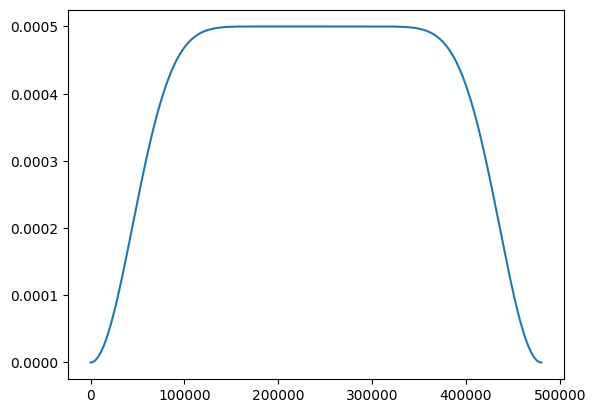

In [10]:
# learning_rates = [optimizer.param_groups[0]['lr']]
# for i_step in range(config.total_steps):
#     schedule.step()
#     learning_rates.append(optimizer.param_groups[0]['lr'])
# plt.plot(learning_rates)

In [6]:
class EMAHelper:
    def __init__(self, model, decay=0.9999):
        self.decay = decay
        self.teacher = copy.deepcopy(model)
        for p in self.teacher.parameters():
            p.requires_grad_(False)

    def update(self, student):
        with torch.no_grad():
            d = self.decay
            for tparam, sparam in zip(self.teacher.parameters(), student.parameters()):
                tparam.copy_(tparam * d + sparam * (1 - d))
    
    def forward(self, x):
        return self.teacher(x)

In [7]:
mixup_tfm = MixUp(alpha=config.mixup_alpha, num_classes=config.classifier_num_classes)

def get_epoch_size(epoch):
    stage_len = config.epochs // len(config.progressive_sizes)
    idx = min(epoch // stage_len, len(config.progressive_sizes)-1)
    return config.progressive_sizes[idx]

def build_train_prebatch_transform(epoch):
    return Compose([
        # Resize(get_epoch_size(epoch), interpolation=InterpolationMode.LANCZOS),
        # RandomCrop(get_epoch_size(epoch), padding=get_epoch_size(epoch)//8, padding_mode='reflect'),
        RandomCrop(get_epoch_size(epoch)),
        PILToTensor(),
        ToDtype(torch.float32,scale=False),
        lambda x: x/127.5 - 1.0,
    ])

def build_valid_transform():
    return Compose([
        # Resize(config.progressive_sizes[-1], interpolation=InterpolationMode.LANCZOS),
        CenterCrop(config.progressive_sizes[-1]),
        PILToTensor(),
        ToDtype(torch.float32,scale=False),
        lambda x: x/127.5 - 1.0,
    ])
    
def train_collate_fn(batch, epoch):
    transform = build_train_prebatch_transform(epoch)
    x_list, y_list = [], []
    for sample in batch:
        img = sample['webp']
        cls_ = sample['cls']
        x_ = transform(img)
        x_list.append(x_)
        y_list.append(cls_)
    x = torch.stack(x_list, dim=0)
    y = torch.tensor(y_list, dtype=torch.long)
    return x, torch.nn.functional.one_hot(y, num_classes=config.classifier_num_classes)

def valid_collate_fn(batch):
    transform = build_valid_transform()
    x_list, y_list = [], []
    for sample in batch:
        img = sample['webp']
        x_ = transform(img)
        y_ = sample['cls']
        x_list.append(x_)
        y_list.append(y_)
    x = torch.stack(x_list, dim=0)
    y = torch.tensor(y_list, dtype=torch.long)
    return x, y

In [ ]:
learning_rates = [optimizer.param_groups[0]['lr']]

ema_helper = EMAHelper(model, decay=config.ema_decay) if config.mesa else None

mb = master_bar(range(config.epochs))
global_step = 0

train_losses = []
valid_accs = []

for i_epoch in mb:
    model.train()
    if ema_helper:
        ema_helper.teacher.eval()

    train_loader = torch.utils.data.DataLoader(
        dataset_train,
        batch_size=config.batch_size,
        shuffle=True,
        num_workers=config.num_workers,
        drop_last=True,
        pin_memory=True,
        collate_fn=lambda batch: train_collate_fn(batch,i_epoch)
    )

    # Training
    pb = progress_bar(train_loader, parent=mb)
    for (x, y) in pb:
        x, y = x.to(device), y.to(device)

        (x, y) = mixup_tfm((x, y))

        if config.label_smoothing>0:
            y = (1 - config.label_smoothing) * y + config.label_smoothing / config.classifier_num_classes

        logits = model(x)
        loss = torch.nn.BCEWithLogitsLoss()(logits, y)
        if global_step % 128 == 0:
            train_losses.append(loss.item())

        if ema_helper:
            frac = i_epoch / config.epochs
            if frac >= config.mesa_start:
                with torch.no_grad():
                    teacher_out = ema_helper.teacher(x)
                teacher_prob = torch.sigmoid(teacher_out)
                student_prob = torch.sigmoid(logits)
                mesa_loss = torch.nn.functional.binary_cross_entropy(student_prob, teacher_prob)
                loss = loss + config.mesa_ratio * mesa_loss

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0, norm_type=2.0)
        optimizer.step()

        if ema_helper:
            ema_helper.update(model)

        schedule.step()
        learning_rates.append(optimizer.param_groups[0]['lr'])
        global_step += 1

    model.eval()
    correct = 0

    val_loader = torch.utils.data.DataLoader(
        dataset_valid,
        batch_size=config.batch_size,
        shuffle=False,
        num_workers=config.num_workers,
        drop_last=False,
        pin_memory=True,
        collate_fn=valid_collate_fn
    )
    for (xv, yv) in progress_bar(val_loader, parent=mb):
        xv, yv = xv.to(device), yv.to(device)
        with torch.no_grad():
            logits_val = model(xv)
        preds = logits_val.argmax(dim=1)
        correct += (preds == yv).sum().item()

    val_acc = correct / dataset_valid.num_rows
    valid_accs.append(val_acc)

    mb.main_bar.comment = f"Epoch={i_epoch} | Train Loss={train_losses[-1]:.4f} | Val Acc={val_acc:.4f}"
    torch.save({
        'i_epoch': i_epoch,
        'model_state_dict': model.state_dict(),
        'ema_state_dict': ema_helper.teacher.state_dict() if ema_helper else None,
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': train_losses,
        'valid_acc': valid_accs,
        'config': vars(config),
    }, f'{config.log_filename}.pth')

In [9]:
display(HTML(mb.main_bar.progress))
display(HTML(mb.child.progress))

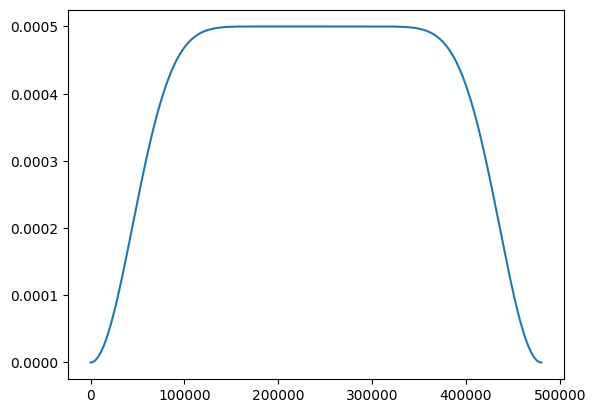

In [10]:
plt.plot(learning_rates)

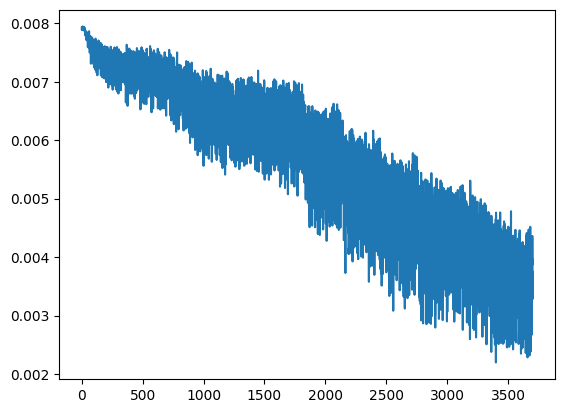

In [11]:
plt.plot(train_losses[50:])

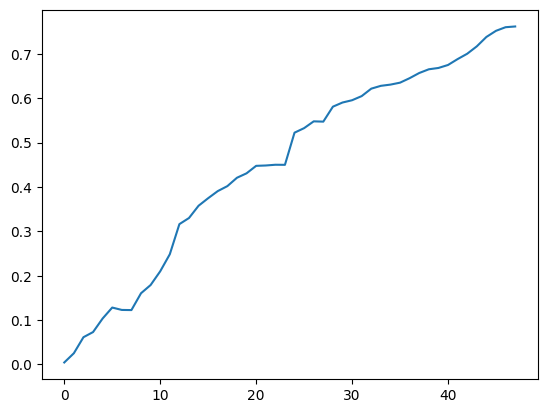

In [12]:
plt.plot(valid_accs)

In [17]:
dataset_valid = load_dataset('timm/imagenet-1k-wds', split='validation')
from torchvision.transforms.v2 import Resize

Resolving data files:   0%|          | 0/1024 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/64 [00:00<?, ?it/s]

In [18]:
ema_helper.teacher.eval()
for resolution, crop_size in [(224,224),(256,224),(256,256),(288,224),(288,256),(288,288)]:
    def valid_collate_fn(batch):
        transform = Compose([
                Resize(resolution, interpolation=PIL.Image.Resampling.LANCZOS),
                CenterCrop(crop_size),
                PILToTensor(),
                ToDtype(torch.float32,scale=False),
                lambda x: x/127.5 - 1.0 ])
        x_list, y_list = [], []
        for sample in batch:
            img = sample['jpg'].convert("RGB")
            x_ = transform(img)
            y_ = sample['cls']
            x_list.append(x_)
            y_list.append(y_)
        x = torch.stack(x_list, dim=0)
        y = torch.tensor(y_list, dtype=torch.long)
        return x, y
        
    val_loader = torch.utils.data.DataLoader(
        dataset_valid,
        batch_size=config.batch_size,
        shuffle=False,
        num_workers=config.num_workers,
        drop_last=False,
        pin_memory=True,
        collate_fn=valid_collate_fn
    )

    correct = 0
    for (xv, yv) in progress_bar(val_loader):
        xv, yv = xv.to(device), yv.to(device)
        with torch.no_grad():
            logits_val =  ema_helper.teacher(xv)
        preds = logits_val.argmax(dim=1)
        correct += (preds == yv).sum().item()
    print(f"resolution: {resolution}, crop size: {crop_size}, acc:{correct/dataset_valid.num_rows}")

resolution: 224, crop size: 224, acc:0.7586


resolution: 256, crop size: 224, acc:0.76234


resolution: 256, crop size: 256, acc:0.76884


resolution: 288, crop size: 224, acc:0.7572


resolution: 288, crop size: 256, acc:0.7714


resolution: 288, crop size: 288, acc:0.7743


In [82]:
ema_helper.teacher.eval()
transform = Compose([
    PILToTensor(),
    ToDtype(torch.float32,scale=False),
    lambda x: x/127.5 - 1.0 ])

for resolution in [192,224,256,288]:
    correct = 0
    seq_len = []
    for sample in progress_bar(dataset_valid):
    
        img = sample['jpg'].convert("RGB")
        aspect = img.width/img.height;
        aspect = 1/aspect if aspect < 1 else aspect
        img = Resize(int(32*((resolution/(aspect)**0.5)//32)),interpolation=PIL.Image.Resampling.LANCZOS)(img)
        img = CenterCrop((32*(img.height//32),32*(img.width//32)))(img)

        xv = transform(img).to(device).unsqueeze(0)
        seq_len.append(xv.shape[2]*xv.shape[3]/32/32)
        yv = torch.tensor(sample['cls'],dtype=torch.long).to(device)
        
        with torch.no_grad():
            logits_val =  ema_helper.teacher(xv)
        preds = logits_val.argmax(dim=1)
        correct += (preds == yv).sum().item()
    print(f"resolution: {resolution}, seq_len: {np.mean(seq_len)}, acc:{correct/dataset_valid.num_rows}")

resolution: 192, seq_len: 28.30166, acc:0.70084


resolution: 224, seq_len: 42.7096, acc:0.74092


resolution: 256, seq_len: 50.47534, acc:0.75186


resolution: 288, seq_len: 66.35892, acc:0.7657


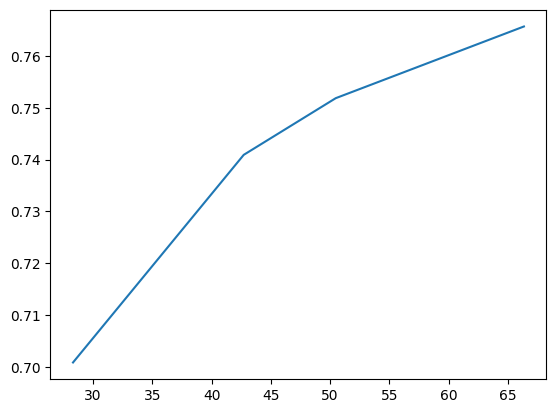

In [84]:
plt.plot(
    [28.30166, 42.7096, 50.47534, 66.35892],
    [0.70084,  0.74092, 0.75186, 0.7657]
)